## Ejercicio 5

**Sobre la imagen microscope.png, aplicar los siguientes pasos**

- Binarizar la imagen (si no está binarizada).
- Obtener la componente conexa de menor tamaño. ¿Cuántos píxeles tiene?
- Recortar la componente conexa de mayor tamaño, y remover el resto de componentes. Mostrar una imagen binaria donde sólo quede la mayor componente conexa
- Aplicar operaciones morfológicas para contar cuántas células hay en total. ¿Comparar el número obtenido contra el número verdadero de células? ¿Son iguales?

### Librerías

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Binarización

In [2]:
# Leer imagen
microscope = cv2.imread("Images/microscope.png", cv2.IMREAD_GRAYSCALE)
# Verificar si la imagen es binaria
unique_values = np.unique(microscope)
if np.array_equal(unique_values, [0, 255]):
    print("Image is binary")
    binary_microscope = microscope
else:
    print("Not a binary image")
    # Convertir a binaria
    _, binary_microscope = cv2.threshold(microscope, 127, 255, cv2.THRESH_BINARY)
    print("SUCCESS: Converted to binary")

Not a binary image
SUCCESS: Converted to binary


### Componentes Conexas

In [3]:
# Encontrar las componentes conexas
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_microscope, connectivity=8)

# Obtener la componente conexa de menor tamaño (excluyendo el fondo)
component_sizes = stats[1:, cv2.CC_STAT_AREA]  # Omitir el fondo (índice 0)
min_size = np.min(component_sizes)
min_component_idx = np.argmin(component_sizes) + 1  # +1 porque el fondo es el índice 0

# Mostrar la cantidad de píxeles de la componente conexa más pequeña
print(f"Smallest component size: {min_size}")

Smallest component size: 158


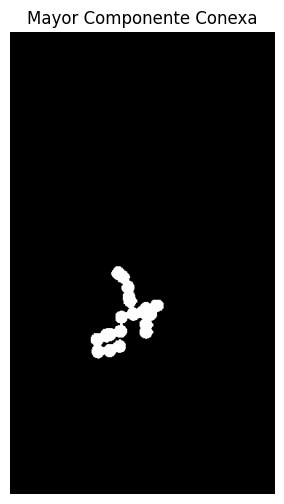

In [4]:
# Obtener la componente conexa de mayor tamaño (excluyendo el fondo)
max_size = np.max(component_sizes)
max_component_idx = np.argmax(component_sizes) + 1  # +1 para no contar el fondo

# Crear una imagen binaria donde solo quede la mayor componente conexa
largest_component_image = np.zeros_like(binary_microscope)
largest_component_image[labels == max_component_idx] = 255

# Mostrar la imagen con solo la componente más grande
plt.figure(figsize=(6,6))
plt.imshow(largest_component_image, cmap='gray')
plt.title("Mayor Componente Conexa")
plt.axis("off")
plt.show()

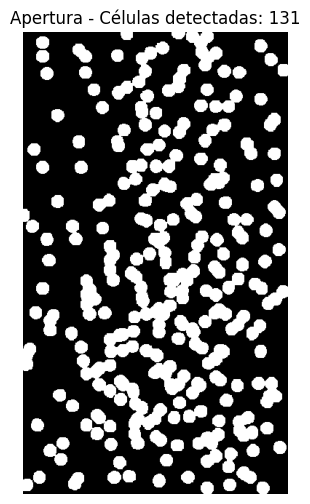

In [5]:
# Aplicar apertura morfológica para eliminar ruido y segmentar las células
kernel = np.ones((3, 3), np.uint8)
processed_image = cv2.morphologyEx(binary_microscope, cv2.MORPH_OPEN, kernel, iterations=2)

# Contar el número de componentes conexas nuevamente
num_labels, _, _, _ = cv2.connectedComponentsWithStats(processed_image, connectivity=8)

# Número de células detectadas (restando el fondo)
num_cells_detected = num_labels - 1

# Mostrar la imagen procesada
plt.figure(figsize=(6,6))
plt.imshow(processed_image, cmap='gray')
plt.title(f"Apertura - Células detectadas: {num_cells_detected}")
plt.axis("off")
plt.show()

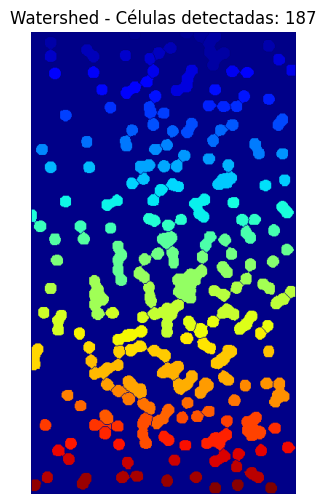

In [6]:
# Aplicar una transformación de distancia para separar mejor las células unidas
distance_transform = cv2.distanceTransform(processed_image, cv2.DIST_L2, 5)

# Normalizar la imagen de distancia
normalized_dist = cv2.normalize(distance_transform, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Umbralizar la transformación de distancia
_, dist_binary = cv2.threshold(normalized_dist, 50, 255, cv2.THRESH_BINARY)

# Refinar los marcadores para Watershed
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(processed_image, kernel, iterations=3)  # Área de fondo seguro
sure_fg = cv2.erode(dist_binary, kernel, iterations=3)  # Área de células seguras
unknown = cv2.subtract(sure_bg, sure_fg)  # Región desconocida

# Etiquetar componentes
_, markers = cv2.connectedComponents(sure_fg)

# Marcar la región desconocida con ceros
markers += 1
markers[unknown == 255] = 0

# Aplicar Watershed
image_color = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)  # Convertir a color para Watershed
cv2.watershed(image_color, markers)

# Contar las nuevas células detectadas
num_cells_true = np.max(markers) - 1  # Restar el fondo

# Mostrar la imagen con las células separadas
plt.figure(figsize=(6,6))
plt.imshow(markers, cmap='jet')
plt.title(f"Watershed - Células detectadas: {num_cells_true}")
plt.axis("off")
plt.show()